In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr,spearmanr
import itertools
from sklearn.cross_decomposition import CCA
import networkx as nx
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [69]:
cells = pd.read_pickle('cells2_salil')
patient_to_group_dict = cells.loc[:,['patients','groups']].drop_duplicates().set_index('patients').to_dict()['groups']
group1_patients = [a for a,gp in patient_to_group_dict.items() if gp==1]
group2_patients = [a for a,gp in patient_to_group_dict.items() if gp==2]

In [70]:
# select which neighborhoods and functional subsets
cns = [0,2,3,4,5,6,7,8,9]
subsets = ['CD8+ICOS+','CD8+Ki67+','CD8+PD-1+','Treg-Ki67+']

In [71]:
#log (1e-3 +  neighborhood specific cell type frequency) of functional subsets) ('nsctf')
nsctf = np.log(1e-3 + cells.groupby(['patients','neighborhood10'])[subsets].mean().reset_index().set_index(['neighborhood10','patients']))

# CCA relative to permutations for group1

In [76]:
cca = CCA(n_components=1,max_iter = 5000)
func = pearsonr

# set number of permutation params
n_perms = 5000
stats_group1 = {}

for cn_i in cns:
    for cn_j in cns:
        if cn_i < cn_j:

            #concat dfs
            combined = pd.concat([nsctf.loc[cn_i].loc[group1_patients],nsctf.loc[cn_j].loc[group1_patients]], axis = 1).dropna(axis = 0, how = 'any')
            x = combined.iloc[:,:len(subsets)].values
            y = combined.iloc[:,len(subsets):].values

            arr = np.zeros(n_perms)

            #compute the canonical correlation achieving components with respect to observed data
            ccx,ccy = cca.fit_transform(x,y)
            stats_group1[cn_i,cn_j] = (pearsonr(ccx[:,0],ccy[:,0])[0],arr)

            #initialize array for perm values

            for i in range(n_perms):
                idx = np.arange(len(x))
                np.random.shuffle(idx)
                # compute with permuted data
                cc_permx,cc_permy = cca.fit_transform(x[idx],y)
                arr[i] = pearsonr(cc_permx[:,0],cc_permy[:,0])[0]





### visualization

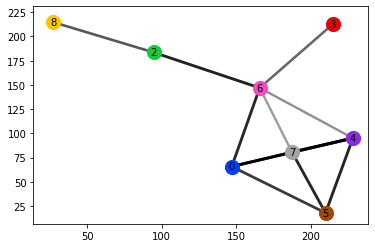

In [96]:
g1 = nx.Graph()
for cn_pair, cc in stats_group1.items():
    s,t = cn_pair
    obs, perms = cc
    p =np.mean(obs>perms)
    if p>0.9 :
        g1.add_edge(s,t, weight = p)
    
    
pal = sns.color_palette('bright',10)
dash = {True: '-', False: ':'}
pos=nx.drawing.nx_pydot.pydot_layout(g1,prog='neato')
for k,v in pos.items():
    x,y = v
    plt.scatter([x],[y],c = [pal[k]], s = 200,zorder = 3)
    plt.text(x,y, k, fontsize = 10, zorder = 10,ha = 'center', va = 'center')


atrs = nx.get_edge_attributes(g1, 'weight')    
for e0,e1 in g1.edges():
    p = atrs[e0,e1]
    plt.plot([pos[e0][0],pos[e1][0]],[pos[e0][1],pos[e1][1]], c= 'black',alpha = 3*p**3,linewidth = 3*p**3)


# CCA relative to permutations for group2

In [77]:
cca = CCA(n_components=1,max_iter = 5000)
func = pearsonr

# set number of permutation params
n_perms = 5000
stats_group2 = {}

for cn_i in cns:
    for cn_j in cns:
        if cn_i < cn_j:

            #concat dfs
            combined = pd.concat([nsctf.loc[cn_i].loc[group2_patients],nsctf.loc[cn_j].loc[group2_patients]], axis = 1).dropna(axis = 0, how = 'any')
            x = combined.iloc[:,:len(subsets)].values
            y = combined.iloc[:,len(subsets):].values

            arr = np.zeros(n_perms)

            #compute the canonical correlation achieving components
            ccx,ccy = cca.fit_transform(x,y)
            stats_group2[cn_i,cn_j] = (pearsonr(ccx[:,0],ccy[:,0])[0],arr)

            #initialize array for perm values

            for i in range(n_perms):
                idx = np.arange(len(x))
                np.random.shuffle(idx)
                cc_permx,cc_permy = cca.fit_transform(x[idx],y)
                arr[i] = pearsonr(cc_permx[:,0],cc_permy[:,0])[0]





### visualization

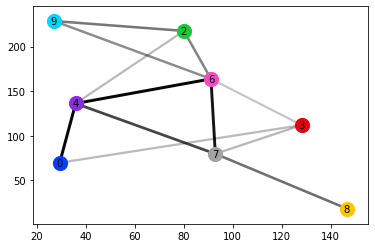

In [97]:
g2 = nx.Graph()
for cn_pair, cc in stats_group2.items():
    s,t = cn_pair
    obs, perms = cc
    p =np.mean(obs>perms)
    if p>0.9 :
        g2.add_edge(s,t, weight = p)
    
    
pal = sns.color_palette('bright',10)
dash = {True: '-', False: ':'}
pos=nx.drawing.nx_pydot.pydot_layout(g2,prog='neato')
for k,v in pos.items():
    x,y = v
    plt.scatter([x],[y],c = [pal[k]], s = 200,zorder = 3)
    plt.text(x,y, k, fontsize = 10, zorder = 10,ha = 'center', va = 'center')


atrs = nx.get_edge_attributes(g2, 'weight')    
for e0,e1 in g2.edges():
    p = atrs[e0,e1]
    plt.plot([pos[e0][0],pos[e1][0]],[pos[e0][1],pos[e1][1]], c= 'black',alpha = 3*p**3,linewidth = 3*p**3)
